# Evaluation of multi-omics GRN inference methods
## Analysis of the inferred GRNs
### by Jalil Nourisa

Competition Overview: https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/overview

#TODO:
- run CO for 3000 genes
- keep less links for CO
- shuffle GRN links

? random compression -> during dimensionality reduction 


- TF acitivity analysis on control
- binding affinity-based TFs of compounds 
- unpaired GRN: train on perturbation data  

# Imports

In [48]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans

import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import decoupler as dc
import seaborn as sns
import json
import anndata as ad
from scipy.sparse import csr_matrix
import category_encoders as ce
import warnings
from sklearn.ensemble import RandomForestRegressor
import decoupler as dc
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold
from sklearn.preprocessing import OneHotEncoder

from venn import venn # https://github.com/LankyCyril/pyvenn/blob/master/pyvenn-demo.ipynb

surragate_names = {'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
                   'sp_grn':'Scenic+', 'sp_ct':'Scenic+', 'sp_grn_sign': 'Scenic+-signs',
                   'co_grn':'CellOracle', 'co_ct':'CellOracle', 'co_grn_sign':'CellOracle-signs',
                   'figr_grn':'FigR', 'figr_ct':'FigR', 'figr_grn_sign':'FigR-signs',
                   'baseline':'Baseline'
                   }

%matplotlib inline
work_dir = '../output'
kaggle_data_dir = '../input/kaggle/input'
os.makedirs(f'{work_dir}', exist_ok=True)

train_cell_types = ['T cells CD4+', 'NK cells', 'T regulatory cells', 'T cells CD8+']
train_sm_names = ['Belinostat', 'CHIR-99021', 'Crizotinib', 'Dabrafenib',
       'Dactolisib', 'Foretinib', 'Idelalisib', 'LDN 193189',
       'Linagliptin', 'O-Demethylated Adapalene', 'Palbociclib',
       'Penfluridol', 'Porcn Inhibitor III', 'R428']
test_celltypes = ['B cells', 'Myeloid cells'] 
agg_type = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
all_cell_types = ['T cells CD4+', 'NK cells', 'T regulatory cells', 'T cells CD8+', 'B cells', 'Myeloid cells']
cell_type_map_agg = {cell_type: 'agg_type' if cell_type in agg_type else cell_type for cell_type in all_cell_types}




controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']

control_compound = 'Dimethyl Sulfoxide'

def calculate_p_values(genes, df):
    '''
    We conduct a 1-sample Kolmogorov-Smirnov (KS) test to detemine p-values for each given gene versus a uniform set.
    Taken from Antoine Passiemier.
    '''
    p_values = []
    for k, gene in tqdm.tqdm(enumerate(genes)):  # Perform test for each gene
        v = df.iloc[:, k].values
        v_valid = v[~np.isnan(v)]
        if len(v_valid)<10:
            raise ValueError('shouldnt be')
        else:
            v_valid = 10 ** (-np.abs(v_valid))  # Transform DE values to p-values (assumed to be uniformly-distributed)
            res = scipy.stats.mstats.ks_1samp(v_valid, scipy.stats.uniform.cdf)  # Kolmogorov-Smirnov test
            p_value = res[1]
        p_values.append(p_value)
    p_values = np.asarray(p_values)
    return p_values

    
def cv_scheme_cell_type():
    cell_types = df_main_reg.index.get_level_values('cell_type')
    train_cell_types = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']
    group_assignments = range(len(train_cell_types))
    group_dict = dict(zip(train_cell_types, group_assignments))
    groups = cell_types.map(group_dict)
    return groups, group_assignments
def cv_scheme_kn10():
    gene_expr_values = df_main_reg.values
    num_clusters = 10 
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(gene_expr_values)
    groups = kmeans.labels_
    group_assignments = range(num_clusters)
    return groups, group_assignments
def cv_scheme_sm_name():
    sm_names = df_main_reg.index.get_level_values('sm_name')
    unique_sm_names = sm_names.unique()
    group_assignments = range(len(unique_sm_names))
    group_dict = dict(zip(unique_sm_names, group_assignments))
    groups = sm_names.map(group_dict)
    return groups, group_assignments
def cv_scheme_sm_name_10():
    n = 10
    sm_names = df_main_reg.index.get_level_values('sm_name')
    unique_sm_names = sm_names.unique().values
    group_assignments = range(n)
    np.random.shuffle(unique_sm_names)
    group_dict = {}
    for i, sm_name in enumerate(unique_sm_names):
        group_dict[sm_name] = i%n
    groups = sm_names.map(group_dict)
    return groups, group_assignments
def cv_scheme_cell_type_plus():
    np.random.seed(32)
    index = df_main_reg.reset_index().index
    index_group = {}
    cv_fold = 0
    for test_cell in train_cell_types:
        mask_test_cell = df_main_reg.index.get_level_values('cell_type')==test_cell
        index_test_cell = index[mask_test_cell]
        index_test_cell_size = index_test_cell.shape[0]
        for fraction in [fraction_test_cell]: # fraction of test cell to be included in train set. 0 equals cell_type cv
            test_size = int((1-fraction)*(index_test_cell_size))
            random_choice = np.random.choice(index_test_cell, size=test_size, replace=False)
            index_group = {**index_group, **{index:cv_fold for index in random_choice}}

            cv_fold+=1
    group_assignments = range(cv_fold)
    groups = index.map(index_group)
    return groups, group_assignments
def cv_scheme_cell_type_two():
    cell_types_cv = ['NK cells', 'T cells CD4+']
    np.random.seed(32)
    index = df_main_reg.reset_index().index
    index_group = {}
    cv_fold = 0
    for test_cell in cell_types_cv:
        mask_test_cell = df_main_reg.index.get_level_values('cell_type')==test_cell
        index_test_cell = index[mask_test_cell]
        index_test_cell_size = index_test_cell.shape[0]
        for fraction in [fraction_test_cell]: # fraction of test cell to be included in train set. 0 equals cell_type cv
            test_size = int((1-fraction)*(index_test_cell_size))
            random_choice = np.random.choice(index_test_cell, size=test_size, replace=False)
            index_group = {**index_group, **{index:cv_fold for index in random_choice}}

            cv_fold+=1
    group_assignments = range(cv_fold)
    groups = index.map(index_group)

    return groups, group_assignments
def cv_scheme_5f():
    num_groups = 5
    group_assignments = range(num_groups)
    group_size = len(df_main_reg) // num_groups
    groups = np.repeat(np.arange(num_groups), group_size)
    if len(df_main_reg) % num_groups != 0:
        groups = np.concatenate((groups, np.arange(len(df_main_reg) % num_groups)))
    np.random.shuffle(groups)
    return groups, group_assignments

def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s

### Significance analysis DE values

In [ ]:
sig_mask = 10 ** (-np.abs(data_df)) < 0.05
df_main_sig = data_df[sig_mask]
values = df_main_sig.values.ravel()

print('Percentage of sig pvalues in df_main_imputed: ', 100*values[~np.isnan(values)].shape[0]/data_df.size)

### Significance analysis using Kolmogorov-Smirnov test

In [ ]:
de_p_values = calculate_p_values(data_df.columns, data_df)
print('number of genes with insufficient samples for p values test: ', np.isnan(de_p_values).sum())
de_p_values_valid = de_p_values[~np.isnan(de_p_values)]
print('portion of sig genes to all genes: ', (de_p_values_valid<0.001).sum()/len(de_p_values_valid))

18211it [00:11, 1523.20it/s]

number of genes with insufficient samples for p values test:  0
portion of sig genes to all genes:  0.7443852616550437


## Filtered data

### Filtering calculated on Kaggle
https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/discussion/466181

In [ ]:
# filter mask
filter_mask_de = pd.read_csv(f'../input/filter_mask_de.csv', index_col=0)
filter_mask_de['cell_type'] = de_train['cell_type']
filter_mask_de['sm_name'] = de_train['sm_name']
filter_mask_de = filter_mask_de.set_index(['cell_type','sm_name'])

### Second filtering mask

In [ ]:
# only those genes with more than= 10 samples
gene_t_filter = filter_mask_de.sum()>=10
# remove those samples with less than 2000 genes
sample_t_filter = filter_mask_de.sum(axis=1)>=2000

### Apply filtering

In [ ]:
# step 1
data_df_f = data_df[filter_mask_de]
print(data_df_f.shape)
# step 2
data_df_f = data_df_f.loc[sample_t_filter, gene_t_filter]

### Stats

In [ ]:
print(data_df_f.shape)
print(data_df_f.reset_index()['cell_type'].unique().shape)
print(data_df_f.reset_index()['sm_name'].unique().shape)

In [ ]:
compound_celltype_size = data_df_f.reset_index()[['sm_name', 'cell_type']].groupby('sm_name').size().reset_index().rename(columns={0:'size'})

plt.figure(figsize=(20, 4))
plt.bar(compound_celltype_size['sm_name'], compound_celltype_size['size'], color='skyblue')

plt.xlabel('Compound')
plt.ylabel('Number of cell type')
plt.xticks([])
plt.show()

### Sparsity

In [ ]:
data_df_f.isna().sum().sum()/data_df_f.size

### What percentage of data is filtered out?

In [ ]:
1-(data_df_f.size-data_df_f.isna().sum().sum())/data_df.size

### Significance analysis

In [ ]:
sig_mask = 10 ** (-np.abs(data_df_f)) < 0.05
df_main_sig = data_df_f[sig_mask]
values = df_main_sig.values.ravel()

print('Percentage of sig pvalues in df_main_imputed: ', 100*values[~np.isnan(values)].shape[0]/data_df_f.size)

### Significance analysis using KS test

In [ ]:
# de_p_values = calculate_p_values(data_df_f.columns, data_df_f)
# print('number of genes with insufficient samples for p values test: ', np.isnan(de_p_values).sum())
# de_p_values_valid = de_p_values[~np.isnan(de_p_values)]
threshold_sig = 0.05/len(de_p_values) # adjust for multiple testing
print('portion of sig genes to all genes: ', (de_p_values_valid<threshold_sig).sum()/len(de_p_values_valid))

portion of sig genes to all genes:  0.5044753171160288


## Imputed data
This will be only used for encoding outputs

In [ ]:
if False:
    from sklearn.impute import KNNImputer
    # Creating the imputer object. You can adjust 'n_neighbors' based on your dataset size and characteristics
    imputer = KNNImputer(n_neighbors=10)
    # Imputing the missing values
    data_df_imputed = pd.DataFrame(imputer.fit_transform(data_df_f), columns=data_df_f.columns, index=data_df_f.index)
    data_df_imputed.to_csv('../input/data_df_f_imputed.csv')
else:
    data_df_imputed = pd.read_csv('../input/data_df_f_imputed.csv')
    data_df_imputed.set_index(['cell_type', 'sm_name'], inplace=True)

In [ ]:
sig_mask = 10 ** (-np.abs(data_df_imputed)) < 0.05
df_main_sig = data_df_imputed[sig_mask]
values = df_main_sig.values.ravel()

print('Percentage of sig pvalues in df_main_imputed: ', 100*values[~np.isnan(values)].shape[0]/data_df_imputed.size)

### Save

In [ ]:
data_df.reset_index().to_csv('../output/postprocess/EDA/data_df.csv')
data_df_f.reset_index().to_csv('../output/postprocess/EDA/data_df_f.csv')
data_df_imputed.reset_index().to_csv('../output/postprocess/EDA/data_df_imputed.csv')

# Process inferred GRNs

## Load saved results

In [ ]:
collectRI = pd.read_csv('../../op_singlecell/input/collectri.csv', index_col=0)
figr_grn = pd.read_csv('../output/figr/grn.csv', index_col=0)
co_grn = pd.read_csv('../output/celloracle/grn/co_grn.csv', index_col=0)
sp_grn = pd.read_csv('../output/scenicplus/grn/grn.csv', index_col=0)

In [ ]:
grn_model_names = ["collectRI", "figr_grn", "co_grn", "sp_grn"]
grn_models = [collectRI, figr_grn, co_grn, sp_grn]
grn_models_dict = {}
for name, model in zip(grn_model_names, grn_models):
    grn_models_dict[name] = model

## Signs of GRNs
We also check GRN performance by only considering the signs of regulation instead of weight.

In [ ]:
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign
grn_models_signs_dict = {}
for name, model in grn_models_dict.items():
    name = f'{name}_sign'
    print(name)
    grn_models_signs_dict[name] = sign_grn(model)
    if model.duplicated().sum()>0:
        duplicates = model.duplicated(keep=False)  # 'keep=False' marks all duplicates as True
        has_duplicates = duplicates.any()
        duplicated_rows = model[duplicates]
        print("Are there any duplicated rows?", has_duplicates)

collectRI_sign
figr_grn_sign
co_grn_sign
sp_grn_sign


## Save GRN models

In [ ]:
for name, grn_model in grn_models_dict.items():
    print(name)
    grn_model.to_csv(f'../output/postprocess/grn_models/{name}.csv')
for name, grn_model in grn_models_signs_dict.items():
    print(name)
    grn_model.to_csv(f'../output/postprocess/grn_models/{name}.csv')

collectRI
figr_grn
co_grn
sp_grn
collectRI_sign
figr_grn_sign
co_grn_sign
sp_grn_sign


## Cis target connections

In [ ]:
# figr
figr_ct = pd.read_csv('../output/figr/peak_gene.csv', index_col=0)[['PeakRanges', 'Gene']]
figr_ct.columns = ['cis','target']


In [ ]:
# co
co_ct = pd.read_csv('../output/celloracle/baseGRN/peak_gene.csv', index_col=0)
co_ct.columns = ['cis','target']

In [ ]:
# cp 
sp_ct = pd.read_csv('../output/scenicplus/grn/grn_extended.csv', index_col=0)[['region', 'target']].drop_duplicates()
sp_ct.columns = ['cis','target']

### Save cis target 

In [ ]:
os.makedirs('../output/postprocess/cis_target', exist_ok=True)
names_ = ["figr_ct", "sp_ct", "co_ct"]
models_ = [figr_ct, sp_ct, co_ct]

for name, grn_model in zip(names_, models_):
    grn_model.to_csv(f'../output/postprocess/cis_target/{name}.csv')


# Topological analysis of inferred GRNs

## Load GRNs

In [ ]:
grn_model_names = ['collectRI', "figr_grn", "co_grn", "sp_grn"]
grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/postprocess/grn_models/{name}.csv', index_col=0)
grn_models_signs_dict = {}
for name in grn_model_names:
    name = f'{name}_sign'
    grn_models_signs_dict[name] = pd.read_csv(f'../output/postprocess/grn_models/{name}.csv', index_col=0)


## Stats of GRN elements

### Regulatory links

In [ ]:
links_n = {name:len(grn) for name, grn in grn_models_dict.items()}
# for cell specific grn models, take the mean
links_n['co_grn'] = grn_models_dict['co_grn'].groupby('cell_type').size().mean()
print(links_n)

{'collectRI': 43178, 'figr_grn': 21324, 'co_grn': 192844.0, 'sp_grn': 33537}


### Regulatory effect

In [ ]:
regulatory_effect_dict = {}
for name, grn in grn_models_signs_dict.items():
    print('-----', name)
    if name in ['co_grn_sign']:
        celltype_counts = grn.groupby('cell_type').weight.value_counts().to_frame().reset_index()
        regulatory_effect_dict['co_grn'] = [celltype_counts[celltype_counts.weight==1]['count'].mean(), celltype_counts[celltype_counts.weight==-1]['count'].mean()]
    else:
        regulatory_effect_dict[name] = grn.weight.value_counts().values # 'positive, negative:
regulatory_effect_dict

----- collectRI_sign
----- figr_grn_sign
----- co_grn_sign
----- sp_grn_sign


{'collectRI_sign': array([37326,  5852]),
 'figr_grn_sign': array([15761,  5563]),
 'co_grn': [119724.0, 73120.0],
 'sp_grn_sign': array([33102,   435])}

### TFs and target genes

In [ ]:
target_genes_dict = {}
tfs_dict = {}
for name, grn in grn_models_dict.items():
    tfs_dict[name] = grn.source.unique() 
    target_genes_dict[name] = grn.target.unique().tolist()

In [ ]:
print('number of TFs')
tfs_dict_n =  {key:len(values) for key,values in tfs_dict.items()}
print(tfs_dict_n)
print('number of targets')
target_genes_dict_n = {key:len(values) for key,values in target_genes_dict.items()}
target_genes_dict_n

number of TFs
{'collectRI': 1186, 'figr_grn': 818, 'co_grn': 593, 'sp_grn': 140}
number of targets


{'collectRI': 6692, 'figr_grn': 7134, 'co_grn': 11497, 'sp_grn': 10789}

### DORCS

In [ ]:
names_ = ["figr_ct", "sp_ct", "co_ct"]
cis_target_df_dict = {}
for name in names_:
    model = pd.read_csv(f'../output/postprocess/cis_target/{name}.csv', index_col=0)
    cis_target_df_dict[name] = model

In [ ]:
# multiple thresholds 
dorcs_n_dict = {}
thresholds_dorcs = range(5, 20)
for name, df in cis_target_df_dict.items():
    stack_ = []
    for t in thresholds_dorcs:
        stack_.append((df.groupby('target').size()>=t).sum())
    dorcs_n_dict[name] = stack_

### Master TFs

In [ ]:
# range of thresholds 
thresholds_master_TFs = range(100,5000,10)
master_tfs_n_dict = {}
for name, grn in grn_models_dict.items():
    stack_ = []
    for t in thresholds_master_TFs:
        size_ = grn.groupby('source').size()
        tfs_n = (size_>=t).sum()
        stack_.append(tfs_n)
    master_tfs_n_dict[name] = stack_

### In-degree for target genes

In [ ]:
thresholds_indegree = range(5,50,1)
indegree_n_dict = {}
for name, grn in grn_models_dict.items():
    stack_ = []
    for t in thresholds_indegree:
        size_ = grn.groupby('target').size()
        tfs_n = (size_>=t).sum()
        stack_.append(tfs_n)
    indegree_n_dict[name] = stack_

### Plot number of GRN elements 

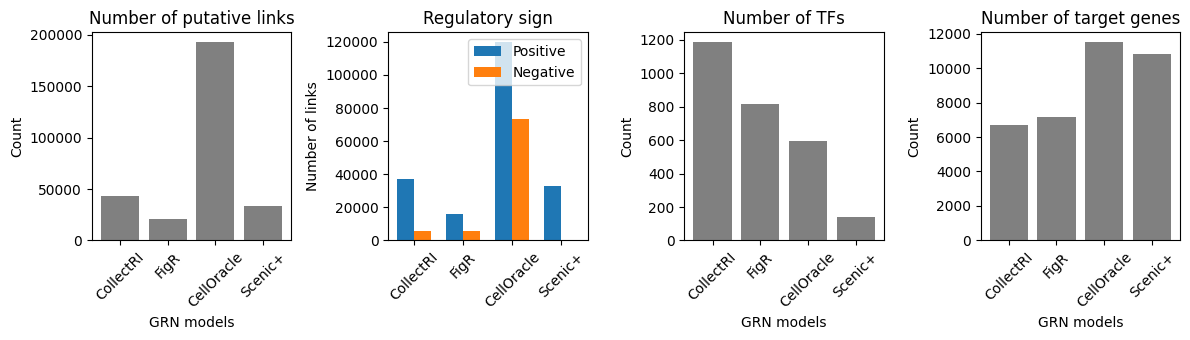

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3.5)) 
color = 'grey'
## number of links
ax = axes[0]
links_n_ = {surragate_names[key]:value for key,value in links_n.items()}
ax.bar(links_n_.keys(), links_n_.values(), color=color)
ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Number of putative links')
# regulatory role 
ax = axes[1]
data = regulatory_effect_dict
categories = list(data.keys())
positive_counts = [data[category][0] for category in categories]
negative_counts = [data[category][1] for category in categories]
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
bars1 = ax.bar(x - width/2, positive_counts, width, label='Positive')
bars2 = ax.bar(x + width/2, negative_counts, width, label='Negative')
ax.set_ylabel('Number of links')
ax.set_title('Regulatory sign')
ax.set_xticks(x)
ax.set_xticklabels([surragate_names[category] for category in categories])
ax.tick_params(axis='x', rotation=45)
ax.legend()

# Rotate category names for better readability
plt.xticks(rotation=45)
## number of TFs
ax = axes[2]
links_n_ = {surragate_names[key]:value for key,value in tfs_dict_n.items()}
ax.bar(links_n_.keys(), links_n_.values(), color=color)
ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Number of TFs')
## number of target 
ax = axes[3]
links_n_ = {surragate_names[key]:value for key,value in target_genes_dict_n.items()}
ax.bar(links_n_.keys(), links_n_.values(), color=color)
ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Number of target genes')
plt.tight_layout()


### Plot intersection of GRN elements
venn diagram

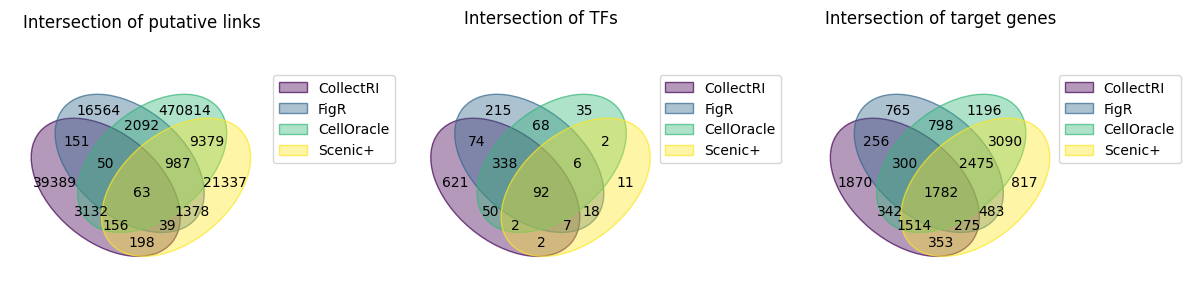

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
# links
ax = axes[0]
grn_fused_dict = {}
for name, grn in grn_models_dict.items():
    grn['link'] = grn['source']+'_'+grn['target']
    grn_fused_dict[name] = grn['link']
grn_fused_dict = {}
for name, grn in grn_models_dict.items():
    grn['link'] = grn['source']+'_'+grn['target']
    grn_fused_dict[name] = grn['link']

dict_set = {surragate_names[key]:set(item) for key,item in grn_fused_dict.items()}
aa = venn(dict_set, hint_hidden=False, fontsize=10, legend_loc=(1,.5), ax=ax)
aa = ax.set_title('Intersection of putative links',pad=1)
# TFs 
ax = axes[1]
tfs_dict_set = {surragate_names[key]:set(item) for key,item in tfs_dict.items()}
aa = venn(tfs_dict_set, hint_hidden=False, 
    figsize=(6, 6), fontsize=10, legend_loc=(.95,.5), ax=ax)
ax.set_title('Intersection of TFs')
# targets 
ax = axes[2]
target_genes_set = {surragate_names[key]:set(item) for key,item in target_genes_dict.items()}
aa = venn(target_genes_set, hint_hidden=False, 
    figsize=(6, 6), fontsize=10, legend_loc=(.95,.5), ax=ax)
ax.set_title('Intersection of target genes')
plt.tight_layout()

#### upsetplot of GRN elements

target genes
TFs


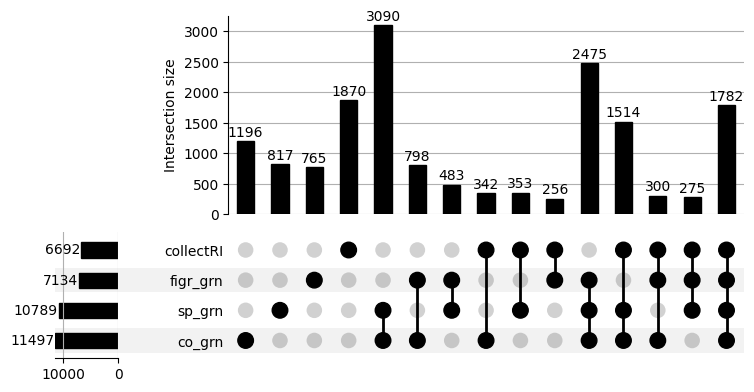

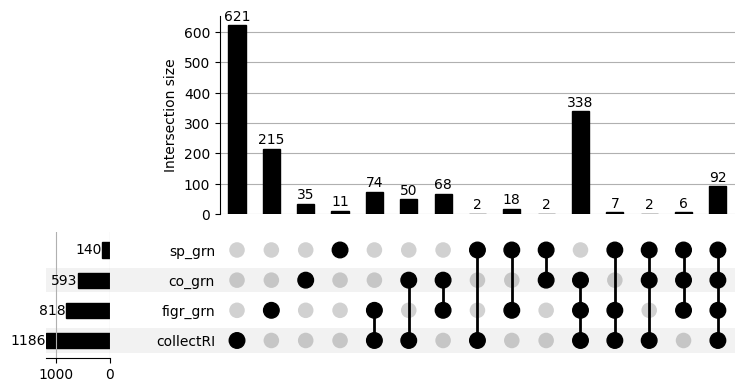

In [ ]:
# Create a set of all unique genes
def convert_df(data):
    all_genes = list(set(gene for genes in data.values() for gene in genes))

    # Initialize DataFrame
    df = pd.DataFrame(index=all_genes)

    # Populate DataFrame
    for key, genes in data.items():
        df[key] = df.index.isin(genes)
    return df
from upsetplot import from_indicators, plot
print('target genes')
aa = plot(from_indicators(indicators=lambda a: a==True, data=convert_df(target_genes_dict)), show_counts=True)
print('TFs')
aa = plot(from_indicators(indicators=lambda a: a==True, data=convert_df(tfs_dict)), show_counts=True)

### Plot connectivity (DORCs, master TFs, etc)

/tmp/ipykernel_149753/1234509918.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


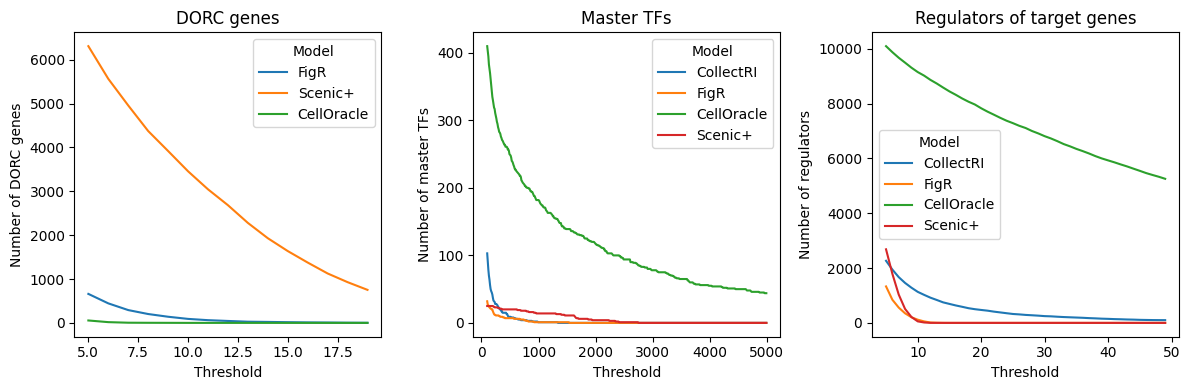

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
## DORCs
ax = axes[0]
data = dorcs_n_dict
x_range = thresholds_dorcs

for key in data:
    ax.plot(x_range, data[key], label=surragate_names[key])
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of DORC genes')
ax.set_title('DORC genes')
ax.legend(title='Model')
## master TFs
ax = axes[1]
data = master_tfs_n_dict
x_range = thresholds_master_TFs
for key in data:
    ax.plot(x_range, data[key], label=surragate_names[key])
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of master TFs')
ax.set_title('Master TFs')
ax.legend(title='Model')
plt.tight_layout()
## in degree for target genes 
ax = axes[2]
data = indegree_n_dict
x_range = thresholds_indegree
for key in data:
    ax.plot(x_range, data[key], label= surragate_names[key])
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of regulators')
ax.set_title('Regulators of target genes')
ax.legend(title='Model')
plt.tight_layout()


# Missingness analysis


In [ ]:
original_data = True

In [ ]:
if original_data:
    df_main = pd.read_csv('../output/postprocess/EDA/data_df.csv', index_col=0).set_index(['cell_type', 'sm_name'])
else:
    df_main = pd.read_csv('../output/postprocess/EDA/data_df_f.csv', index_col=0).set_index(['cell_type', 'sm_name'])


## Missing significant target genes 

In [ ]:
de_p_values = calculate_p_values(df_main.columns, df_main)

18211it [00:12, 1515.73it/s]


In [ ]:
def evaluate_sig_gene_missing(missing_genes, df_main, threshold=0.05):
    sig_t = threshold/len(de_p_values) # accounting for multiple testing
    sig_mask = de_p_values < sig_t
    sig_genes = df_main.columns[sig_mask]
    missing_sig_genes = np.intersect1d(missing_genes, sig_genes)
    return  missing_sig_genes
missing_genes_dict = {}
missing_sig_genes_n_dict = {}
thresholds_sigs = [0.05, 0.01, 0.001, 0.0001]
for name, grn in grn_models_dict.items():
    print(f'\n------ {name}-------')
    genes = grn.target.unique()
    shared_genes = np.isin(df_main.columns, genes)
    missing_genes = df_main.columns[~shared_genes].tolist()
    missing_genes_dict[name] = missing_genes
    stack_ = []
    for t in thresholds_sigs:
        missing_sig_genes = evaluate_sig_gene_missing(missing_genes, df_main, threshold=t)
        stack_.append(len(missing_sig_genes))
    missing_sig_genes_n_dict[name] = stack_


------ collectRI-------

------ figr_grn-------

------ co_grn-------

------ sp_grn-------


In [ ]:
print('missing genes')
print({surragate_names[key]:len(value) for key,value in missing_genes_dict.items()})
print('missing sig genes for different thresholds')
missing_sig_genes_n_dict

missing genes
{'CollectRI': 13580, 'FigR': 12001, 'CellOracle': 7219, 'Scenic+': 8452}
missing sig genes for different thresholds


{'collectRI': [7091, 6058, 4546, 3150],
 'figr_grn': [6305, 5399, 4063, 2843],
 'co_grn': [5323, 4627, 3494, 2421],
 'sp_grn': [5665, 4899, 3679, 2552]}

### intersection of missing target genes 

In [ ]:

missing_sig_genes_001_dict = {}
for name, grn in grn_models_dict.items():
    print(f'\n------ {name}-------')
    genes = grn.target.unique()
    shared_genes = np.isin(df_main.columns, genes)
    missing_genes = df_main.columns[~shared_genes].tolist()
    
    missing_sig_genes_001_dict[name] = evaluate_sig_gene_missing(missing_genes, df_main, threshold=0.001)


------ collectRI-------
['A1BG', 'A1BG-AS1', 'A2M-AS1', 'A2MP1', 'AAAS']

------ figr_grn-------
['A1BG-AS1', 'A2MP1', 'A4GALT', 'AACS', 'AAGAB']

------ co_grn-------
['A1BG', 'A1BG-AS1', 'A2M-AS1', 'A2MP1', 'A4GALT']

------ sp_grn-------
['A1BG-AS1', 'A2M-AS1', 'A2MP1', 'A4GALT', 'AAR2']


## Missing significant measurments 

In [ ]:
def evaluate_sig_measur(genes, df_main, threshold=0.05):
    sig_t = threshold
    df_sg = 10 ** (-np.abs(df_main))
    
    all_sig = (df_sg < sig_t).sum().sum()
    
    mask_missing = ~df_main.columns.isin(genes)
    # print(df_sg.loc[:,mask_missing].shape)
    # print(df_sg.loc[:,mask])
    missing_sig = (df_sg.loc[:,mask_missing] < sig_t).sum().sum() 
    return  missing_sig/all_sig
missing_sig_measur = {}
thresholds_sigs = [0.05, 0.01, 0.001, 0.0001]
for name, grn in grn_models_dict.items():
    print(f'\n------ {name}-------')
    genes = grn.target.unique()
    stack_ = []
    for t in thresholds_sigs:
        missing_sig = evaluate_sig_measur(genes, df_main, threshold=t)
        stack_.append(missing_sig)
    missing_sig_measur[name] = stack_


------ collectRI-------

------ figr_grn-------

------ co_grn-------

------ sp_grn-------


## Plot missingness

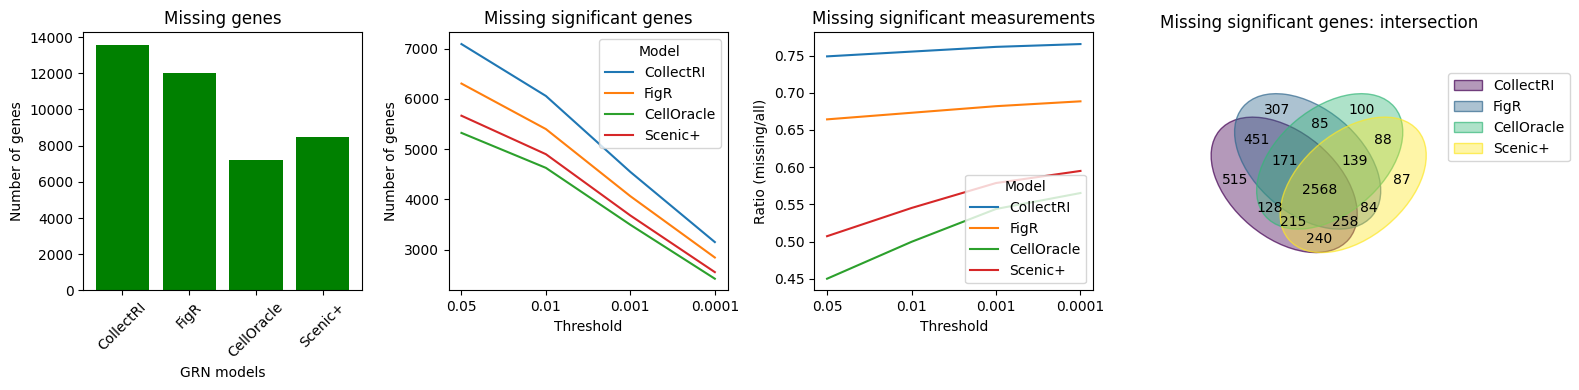

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4)) 
# missing genes 
ax = axes[0]
links_n_ = {surragate_names[key]:len(value) for key,value in missing_genes_dict.items()}
ax.bar(links_n_.keys(), links_n_.values(), color=color)
ax.set_xlabel('GRN models')
ax.set_ylabel('Number of genes')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Missing genes')
## missing sig genes 
ax = axes[1]
data = missing_sig_genes_n_dict
x_range = thresholds_sigs
for key in data:
    ax.plot(range(len(x_range)),data[key], label=surragate_names[key])
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of genes')
ax.set_title('Missing significant genes')
ax.set_xticks(range(len(x_range)))
ax.set_xticklabels(x_range)
ax.legend(title='Model')
## missing sig measurements
ax = axes[2]
data = missing_sig_measur
x_range = thresholds_sigs
for key in data:
    ax.plot(range(len(x_range)),data[key], label=surragate_names[key])
ax.set_xlabel('Threshold')
ax.set_ylabel('Ratio (missing/all)')
ax.set_title('Missing significant measurements')
ax.set_xticks(range(len(x_range)))
ax.set_xticklabels(x_range)
ax.legend(title='Model')
## intersection 
ax = axes[3]
dict_set = {surragate_names[key]:set(item) for key,item in missing_sig_genes_001_dict.items()}
aa = venn(dict_set, hint_hidden=True, fontsize=10, legend_loc=(1,.5), ax=ax)
aa = ax.set_title('Missing significant genes: intersection',pad=1)

plt.tight_layout()

In [ ]:
# housekeeping genes
df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)
housekeeping_genes = df.loc[:, 0]  # Gene names
housekeeping_genes_filter = np.isin(data_df.columns, housekeeping_genes)
print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

# Regression analysis 

In [2]:
data_type = 'raw' # 'de_train', 'raw'
cv_scheme = 'sm_name_10' # 'cell_type', 'sm_name', '10cv', 'sm_name_10', 'kn10', cell_type_plus
fraction_test_cell = 0.2


## Training data

In [3]:
print(data_type)
if data_type == 'de_train':
    # df_main_reg = pd.read_csv('../output/postprocess/EDA/data_df.csv', index_col=0).set_index(['cell_type', 'sm_name'])
    df_main_reg = pd.read_parquet('../output/de_analysis/limma/de_train_t.parquet')
    # df_main_reg = pd.read_parquet('../output/de_analysis/edger/voom_lmfit/de_train_t.parquet')
elif data_type == 'raw':
    bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row']
    # bulk_adata = ad.read_h5ad('../output/de_analysis/bulk_adata_f.h5ad')
    bulk_adata = ad.read_h5ad('../output/de_analysis/bulk_adata_f_n_pearson.h5ad')
    bulk_adata_df = pd.DataFrame(bulk_adata.X, columns=bulk_adata.var.gene, index=bulk_adata.obs.index)
    bulk_adata_df = pd.concat([bulk_adata.obs[bulk_index],  bulk_adata_df], axis=1).set_index(bulk_index)
    df_main_reg = bulk_adata_df
else:
    raise ValueError('')

df_main_reg.shape

raw


(2197, 10750)

### Number of SVDs to summarize train data

In [4]:
from sklearn.decomposition import TruncatedSVD, PCA

def func_svds(explained_variance_t=0.9): 
    """Determine number of SVDs to explain explained_variance_t"""
    n_components = 500
    reducer = TruncatedSVD(n_components=n_components, random_state=32) 
    reducer.fit(df_main_reg)
    variance_explained = reducer.explained_variance_ratio_.cumsum()
    n_components = sum(variance_explained < explained_variance_t) + 1  # Number of components to capture 90% variance
    print(f"Number of components to retain {explained_variance_t} of the variance: {n_components}")
    return n_components
if True:
    n_components = func_svds()
    print(n_components)
    n_components = min([35, n_components])
    

Number of components to retain 0.9 of the variance: 486
486


## GRNs


In [5]:
# grn_model_names = ['collectRI', "figr_grn"]
# grn_model_names = []
grn_model_names = ["collectRI", "figr_grn", "co_grn", "sp_grn"]
# grn_model_names = ["sp_grn"]
grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/postprocess/grn_models/{name}.csv', index_col=0)
grn_models_signs_dict = {}
for name in grn_model_names:
    if name in ['collectRI']:
        continue
    name = f'{name}_sign'
    grn_models_signs_dict[name] = pd.read_csv(f'../output/postprocess/grn_models/{name}.csv', index_col=0)


grn_models_shuffled_dict = {}
for name, grn in grn_models_dict.items():
    grn_s = shuffle_grn(grn)
    name = f'{name}_shuffled'
    grn_models_shuffled_dict[name] = grn_s
# grn_models_all_dict = grn_models_dict 
# grn_models_all_dict = {}
# grn_models_all_dict = grn_models_dict
grn_models_all_dict = grn_models_dict | grn_models_signs_dict | grn_models_shuffled_dict

# del grn_models_all_dict['collectRI_sign']
grn_models_all_dict.keys()
# del grn_models_all_dict['collectRI_sig']

dict_keys(['collectRI', 'figr_grn', 'co_grn', 'sp_grn', 'figr_grn_sign', 'co_grn_sign', 'sp_grn_sign', 'collectRI_shuffled', 'figr_grn_shuffled', 'co_grn_shuffled', 'sp_grn_shuffled'])

## TF enrichment model

In [6]:
def enrich_tfs_single(df_main_c, net):
    estimate, pvals = dc.run_ulm(
                df_main_c,
                net,
                # source='source',
                # target='target',
                # weight='weight',
                verbose=False
                )
    return estimate
def enrich_tfs_single_custom(df_main_c, net):
    from skranger import ensemble
    df = df_main_c.copy()
    net_genes = net.target.unique()
    shared_genes = np.intersect1d(net_genes, df.columns)

    net = net[net.target.isin(shared_genes)]
    y = df[shared_genes].values

    X = net.pivot(index='target', columns='source', values='weight').fillna(0)

    # regr_list = []
    # for i in tqdm.tqdm(range(y.shape[1])):
    #     regr = ensemble.RangerForestRegressor(n_estimators=100, n_jobs=10,
    #                                 seed=32, importance='impurity', oob_error=True)
    #     regr.fit(X, y[:, i])
    #     regr_list.append(regr)
    estimate = np.dot(y, X)
    
    return pd.DataFrame(estimate, index=df_main_c.index)

def enrich_tfs(df_main, net):
    "TF enrichment score cell specific grns"
    df_main_c = df_main.copy()
    df_main_c.index = df_main.index.map(lambda x: '@'.join(map(str, x))) # this is needed for enrichment analyisis
    if 'cell_type' in net:
        cell_type_index = df_main.index.get_level_values('cell_type')
        # EA for each cell type
        tf_act_stack = []
        for cell_type in net.cell_type.unique():
            if cell_type == 'agg_type':
                mask = cell_type_index.isin(agg_type)
            else:
                mask = cell_type_index==cell_type
            df_main_celltype = df_main_c[mask]

            net_celltype = net[net.cell_type==cell_type]
            tf_act = enrich_tfs_single(df_main_celltype, net_celltype)
            tf_act_stack.append(tf_act)
        tf_act_df = pd.concat(tf_act_stack).fillna(0)
        tf_act_df = tf_act_df.reindex(df_main_c.index)
            
    else:
        tf_act_df = enrich_tfs_single(df_main_c, net)
    return tf_act_df

# net = grn_models_all_dict['collectRI']
# tf_acts =  enrich_tfs(df_main_reg, net)
# tf_acts.shape

### Clusters


In [7]:
if False:
    tf_acts.index= df_main_reg.index
    obs=tf_acts.index.to_frame().reset_index(drop=True)
    var=pd.DataFrame(index=tf_acts.columns)
    adata = anndata.AnnData(X=tf_acts.values, obs=obs , var=var)
    with warnings.catch_warnings():
        # sc.pp.normalize_per_cell(adata)
        sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=False)
        sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
        sc.tl.umap(adata)
        sc.pl.umap(adata, color=['cell_type'], frameon=False)
        sc.pl.pca(adata, color=['cell_type'], frameon=False)

### Number of SVDs to summarize TF scores

In [8]:
if False:
    from sklearn.decomposition import PCA, TruncatedSVD

    def func_svds(df, net, explained_variance_t=0.9): 
        """Determine number of SVDs to explain 90% of varaince"""
        df_main_c = df.copy()
        tf_act = enrich_tfs(df_main_c, net)
        # print(tf_act.iloc[0:3,:5])
        n_components = min([500, tf_act.shape[1]])
        # reducer = TruncatedSVD(n_components=n_components, n_iter=10, random_state=32)
        reducer = PCA(n_components=n_components, random_state=32) 
        reducer.fit(tf_act)
        variance_explained = reducer.explained_variance_ratio_.cumsum()
        n_components = sum(variance_explained < explained_variance_t) + 1  # Number of components to capture 90% variance
        print(f"Number of components to retain {explained_variance_t} of the variance: {n_components}")
        return n_components
    if False:
        n_components_dict = {}
        for name, grn in grn_models_all_dict.items():
            print('----',name)
            if subset_genes:
                print('subsetting for gene')
                genes_mask = df_main_reg.columns.isin(grn.target) # mask on genes
                df_main_reg_tailored = df_main_reg.loc[:, genes_mask] # subset training data for given genes
            else:
                df_main_reg_tailored = df_main_reg
            # print('number of target genes: ', len(df_main_reg_tailored.columns))
            # print('tfs: ', grn.source.unique().shape)
            n_components_dict[name] = func_svds(df_main_reg_tailored, grn)

## Multivariate trees 

In [76]:
def cv_5(genes_n):
    '''5 fold standard'''
    num_groups = 5
    group_size = genes_n // num_groups
    groups = np.repeat(np.arange(num_groups), group_size)
    if genes_n % num_groups != 0:
        groups = np.concatenate((groups, np.arange(genes_n % num_groups)))
    np.random.shuffle(groups)
    return groups
if True:
    def run_mvt(net, reg_type='ridge', 
                    params_RF=dict(n_estimators=100, n_jobs=10, oob_score=True),
                    params_ridge = dict(alpha=100), 
                    cv_type='5cv') -> None:     
            #
            df = df_main_reg.copy()

            # combined agg cell types
            df = df.reset_index(level='cell_type').set_index('cell_type') 
            mapped_celltypes = df.index.map(cell_type_map_agg)
            df.index = mapped_celltypes

            # determine regressor 
            if reg_type=='ridge':
                params = {**params_ridge, 'random_state':32}
                print(params)
                regr =Ridge(**params)
            elif reg_type=='RF':
                params = {**params_RF, 'random_state':32}
                regr = RandomForestRegressor(**params)
            else:
                raise ValueError("define first")

            
            # for each cell type
            cell_type_index = df.index
            score_list = []
            sample_n_list = []
            for cell_type in cell_type_index.unique():
                print('---- ', cell_type,' --------')
                # subset df for cell type 
                if cell_type in agg_type:
                    mask = cell_type_index.isin(agg_type)
                else:
                    mask = cell_type_index==cell_type
                df_celltype = df[mask]

                # net is cell type dependent or not 
                if 'cell_type' in net:
                    net_celltype = net[net.cell_type==cell_type]
                else:
                    net_celltype = net.copy()

                # match net and df in terms of shared genes 
                net_genes = net_celltype.target.unique()
                shared_genes = np.intersect1d(net_genes, df.columns)
                net_celltype = net_celltype[net_celltype.target.isin(shared_genes)]

                # define X and Y 
                Y = df_celltype[shared_genes].values.T
                X = net_celltype.pivot(index='target', columns='source', values='weight').fillna(0).values
                print(f'X (genes, TFs): {X.shape}, Y (genes, samples): {Y.shape}')

                # define cv scheme
                if cv_type=='5cv': 
                    groups = cv_5(X.shape[0])
                elif cv_type=='5cv_cluster':
                    groups = cv_5_cluster(Y)
                
                # run cv 
                Y_pred_stack = []
                Y_true_stack = []
                unique_groups = np.unique(groups)
                
                for group in unique_groups:
                    mask_va = groups==group
                    mask_tr = ~mask_va

                    X_tr, Y_tr = X[mask_tr,:], Y[mask_tr,:]
                    X_va, Y_true = X[mask_va,:], Y[mask_va,:]

                    regr.fit(X_tr, Y_tr)
                    Y_pred = regr.predict(X_va)

                    Y_pred_stack.append(Y_pred)
                    Y_true_stack.append(Y_true)

                y_pred = np.concatenate(Y_pred_stack, axis=0)
                y_true = np.concatenate(Y_true_stack, axis=0)
                score  = r2_score(y_true, y_pred, multioutput='variance_weighted')
                print(f'Score: ', score)
                score_list.append(score)
                sample_n_list.append(y_true.shape[1])
            # mean score 
            sample_n_list, score_list = np.asarray(sample_n_list), np.asarray(score_list)
            mean_score = np.sum(sample_n_list*score_list)/sample_n_list.sum()
            print('overall score: ', mean_score)

    net = grn_models_all_dict['figr_grn']
    run_mvt(net)

{'alpha': 100, 'random_state': 32}
----  NK cells  --------
X (genes, TFs): (4509, 813), Y (genes, samples): (4509, 528)
Score:  0.11930117589574445
----  agg_type  --------
X (genes, TFs): (4509, 813), Y (genes, samples): (4509, 1309)
Score:  0.14809516386818708
----  B cells  --------
X (genes, TFs): (4509, 813), Y (genes, samples): (4509, 180)
Score:  0.2895380444960166
----  Myeloid cells  --------
X (genes, TFs): (4509, 813), Y (genes, samples): (4509, 180)
Score:  0.29667131225048604
overall score:  0.16493640172543486


,AATF,ABHD12,ABHD3,AC004687.1,AC024293.1,AC026412.1,AC084033.3,AC116533.1,AC245100.8,ACD,...,PHLDA3,ATP9A,NXPH4,ZNF365,CARD17,BFSP2,MT1L,MMEL1,DKK3,NR4A1
cell_type,,,,,,,,,,,,,,,,,,,,,
NK cells,-0.277028,-1.362204,0.180501,5.927776,-0.973070,1.362281,0.199805,0.413208,1.388439,-1.652135,...,0.616123,1.635351,1.905493,-0.482342,-0.391531,-0.380842,-0.491651,-0.480459,-0.445183,6.268307
agg_type,-1.149945,-3.639569,-0.680782,-0.527289,0.649408,0.612351,1.133161,-0.937112,-2.508268,0.398930,...,-0.904198,-0.995026,-0.900186,1.913755,0.380611,-0.801907,-1.033512,-0.030347,-0.936530,-0.938077
agg_type,0.256136,-1.301975,-1.195216,-0.237798,-0.045944,3.381416,2.111769,1.132042,-0.380470,0.313351,...,-0.376286,-0.241732,-0.218505,-0.246412,-0.199961,-0.194495,-0.251175,-0.245448,-0.227399,-0.227778
B cells,0.890874,-3.413275,-1.979020,6.157181,-0.914833,6.796588,-2.302118,-2.163967,-0.980104,1.252422,...,-1.370819,-0.885171,5.404237,-0.902178,-0.733053,3.472399,-0.919484,-0.898676,-0.833035,1.545791
Myeloid cells,2.591227,27.042607,-0.226056,-6.385596,-6.281797,-2.369764,-3.520891,-4.958123,-5.210626,-1.612470,...,0.168464,-1.501134,-1.359631,-1.529536,-1.246065,-1.212502,-0.932317,-0.882624,-1.413915,-0.032344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
agg_type,-0.106869,-1.068816,0.404436,-1.467996,-0.593839,0.141517,0.368277,-1.384211,-0.890180,-0.177830,...,-0.480983,12.620502,-0.279385,-0.315053,7.561490,7.788368,-0.321142,-0.313822,-0.290753,-0.291237
NK cells,2.857201,-2.425624,2.596198,9.728230,-1.348627,-1.573131,1.612210,-1.115984,2.191993,0.264493,...,-0.820745,1.360261,-0.477442,1.314078,-0.436985,-0.425059,-0.548668,1.323479,1.510921,1.506746
agg_type,-0.043648,-3.816266,0.073404,0.432713,1.131028,-0.835023,-0.280562,-1.000821,1.056033,1.434735,...,-0.367351,-1.029925,-0.931819,1.776932,1.473455,-0.830137,-1.069731,-0.099654,-0.969418,-0.971018


In [ ]:
Ridge: 0.32
RF: 0.2942594697733679

0.26483145821910986

In [ ]:
aa

## geneRNI fit

In [ ]:
if True:
    from skranger import ensemble
    class generni:
        def __init__(self, net) -> None:
            df = df_main_reg.copy()
            net_genes = net.target.unique()
            shared_genes = np.intersect1d(net_genes, df.columns)

            net = net[net.target.isin(shared_genes)]
            net = net[net.source.isin(df.columns)] # tfs should be as genes
            X_stack = []
            Y_stack = []

            for i, gene in enumerate(net.target.unique()):
                tfs = net[net.target== gene].source.unique()
                X_stack.append(df[tfs])
                Y_stack.append(df.iloc[:,i])

            self.X_stack = X_stack
            self.Y_stack = Y_stack

            print('number of genes: ', len(self.X_stack))

        def validate(self, mask_tr, mask_va):            
            oob_error_list = []
            Y_pred_stack = []
            Y_true_stack = []

            for i in tqdm.tqdm(range(len(self.Y_stack))):
                X = np.asarray(self.X_stack[i])
                Y =  np.asarray(self.Y_stack[i])
                X_tr, Y_tr = X[mask_tr,:], Y[mask_tr]
                X_va, Y_true = X[mask_va,:],Y[mask_va]
        
                # regr = ensemble.RangerForestRegressor(n_estimators=100, n_jobs=10,  seed=32, importance='impurity', oob_error=True)
                regr = Ridge(alpha=10, random_state=32)
                regr.fit(X_tr, Y_tr)
                Y_pred_stack.append(regr.predict(X_va))
                # print(regr.score(X_tr, Y_tr))
                Y_true_stack.append(Y_true)
                # oob_error_list.append(regr.ranger_forest_['prediction_error'])
            # oob_error = np.mean(oob_error_list)
            oob_error = None
            Y_pred = np.asarray(Y_pred_stack).T
            Y_true = np.asarray(Y_true_stack).T

            return oob_error, Y_pred, Y_true
        def CV(self):
            groups, group_assignments = cv_scheme_5f()
            # groups, group_assignments = cv_scheme_cell_type_two()

            Y_pred_stack = []
            Y_true_stack = []
            oob_error_stack = []

            for group in group_assignments:
                print('CV ', group)
                mask_va = groups==group
                mask_tr = ~mask_va
                oob_error, Y_pred, Y_true = self.validate(mask_tr, mask_va)
                oob_error_stack.append(oob_error)
                Y_pred_stack.append(Y_pred)
                Y_true_stack.append(Y_true)
                print(r2_score(Y_true, Y_pred, multioutput='variance_weighted'))
            return oob_error_stack, Y_pred_stack, Y_true_stack

    net = grn_models_all_dict['figr_grn_shuffled']
    model = generni(net)
    oob_error_list, Y_pred_stack, Y_true_stack = model.CV()
    y_pred_all = np.concatenate(Y_pred_stack, axis=0)
    y_true_all = np.concatenate(Y_true_stack, axis=0)
    r2score  = r2_score(y_true_all, y_pred_all, multioutput='variance_weighted')
    print(r2score)

number of genes:  4200
CV  0


100%|██████████| 4200/4200 [00:04<00:00, 954.22it/s] 


0.31209961323314334
CV  1


100%|██████████| 4200/4200 [00:04<00:00, 911.92it/s] 


0.3448866262123997
CV  2


100%|██████████| 4200/4200 [00:04<00:00, 926.52it/s] 


0.33724075339512605
CV  3


100%|██████████| 4200/4200 [00:04<00:00, 916.36it/s] 


0.3633962148219907
CV  4


100%|██████████| 4200/4200 [00:04<00:00, 936.19it/s] 


0.28462627620242786
0.3310606201187243


## Regression models

### Encoder

In [ ]:
# from py_boost import GradientBoosting
random_state = 32
id_map = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/id_map.csv', index_col=0)

class model_encoder:
    def __init__(self, df_main, n_components_y=20, 
                    n_encode_tfs = 20,
                    te_params = dict(min_samples_leaf=20, smoothing=100),
                    grn_model=None
                    ):  
        # target df to encode
        self.n_encode_tfs = n_encode_tfs
        self.df_main = df_main
        self.grn_model = grn_model
        # regressor
        # self.emb_model = RandomForestRegressor(n_estimators=100, random_state=random_state)

        # self.emb_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=random_state))
        self.emb_model = Ridge(alpha=10, random_state=random_state)
        # self.emb_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
        self.reducer = TruncatedSVD(n_components=n_components_y, n_iter=12, random_state=random_state)
        self.Y = self.reducer.fit_transform(df_main)
        # encoder 
        self.enc = ce.TargetEncoder(**te_params) #[0, 0.05, 0.5, 0.1,0.9,10]
        # encode data
        self.emb_data = self.create_feature_space(self.df_main)
        self.determine_X()
        print(self.X.shape)
    def ohe(self, hot_encoding_features):
        for i, feature in tqdm.tqdm(enumerate(hot_encoding_features)):
            X_encoded = pd.get_dummies(self.df_main.reset_index()[feature], columns=[feature]).values
            if i == 0:
                X = X_encoded
                # X_submit = X_submit_encoded
            else:
                X = np.concatenate([X, X_encoded], axis = 1)
                # X_submit = np.concatenate([X_submit, X_submit_encoded], axis = 1)
        return X
    def target_encoding(self, feature_x, target_encoding_features):
        for i, feature in tqdm.tqdm(enumerate(target_encoding_features)):
            unique_names = self.df_main.index.get_level_values(feature).unique()
            n_components_enc = min([len(unique_names), feature_x.shape[1]])
            for i_target in tqdm.tqdm(range(n_components_enc)):
                if i_target == 0:
                    X_encoded = self.enc.fit_transform(self.df_main.reset_index()[feature], feature_x[:,i_target])
                    # X_submit_encoded = self.enc.transform(id_map.reset_index()[feature])
                else:
                    X_encoded_tmp = self.enc.fit_transform(self.df_main.reset_index()[feature], feature_x[:,i_target])
                    X_encoded = np.concatenate([X_encoded, X_encoded_tmp], axis = 1)
                    # X_encoded_tmp = self.enc.transform(id_map.reset_index()[feature])
                    # X_submit_encoded = np.concatenate([X_submit_encoded, X_encoded_tmp], axis = 1)
            if i==0:
                X = X_encoded
            else:
                X = np.concatenate([X, X_encoded], axis = 1)
        return X
    def determine_X(self):
        features = self.df_main.index.names
        feature_x = self.emb_data
        if self.grn_model is None:
            X = self.ohe(features)        
        else:
            X = self.target_encoding(feature_x, features)        
        self.X = X
    def create_feature_space(self, df_to_encode):
        if self.grn_model is not None:
            df_main_c = df_to_encode.copy()
            net = self.grn_model
            tf_act = enrich_tfs(df_main_c, net)
            if False: # to variable
                variances = tf_act.var()
                sorted_variances = variances.sort_values(ascending=False)
                top_tfs = sorted_variances.index.tolist()
                tf_act = tf_act[top_tfs].values
            elif True: # SVD
                n_components = min([tf_act.shape[1], 30])
                tf_act = TruncatedSVD(n_components=n_components, n_iter=12, random_state=random_state).fit_transform(tf_act)
            else: # keep the actual TF scores
                tf_act = tf_act.values
            return tf_act
    def validate(self, mask_tr, mask_va):
        X_tr, Y_tr = self.X[mask_tr,:], self.Y[mask_tr,:]
        X_va = self.X[mask_va,:]
        self.emb_model.fit(X_tr, Y_tr)
        y_pred = self.emb_model.predict(X_va)
        return self.reducer.inverse_transform(y_pred)
        # return self.emb_model.predict(X_va)
# net = grn_models_all_dict['figr_grn']
# mm = model_encoder(df_main_reg, grn_model=net)
mm.emb_model = Ridge(alpha=10, random_state=random_state)
compute_cv(mm, df_main_reg)


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 29.75it/s]


(0.4569953667508665, 0.9078907703692082)

In [ ]:
cv_scheme = 'cell_type_plus'
if cv_scheme =='kn10':
    groups, group_assignments = cv_scheme_kn10()
elif cv_scheme=='sm_name': # cluster of sm_name
    groups, group_assignments = cv_scheme_sm_name()
elif cv_scheme=='sm_name_10': # cluster of sm_name
    groups, group_assignments = cv_scheme_sm_name_10()
elif cv_scheme=='cell_type': # one group for each trainig cell_type
    groups, group_assignments = cv_scheme_cell_type()
elif cv_scheme=='5cv':
    groups, group_assignments = cv_scheme_5f()
elif cv_scheme=='cell_type_plus':
    groups, group_assignments = cv_scheme_cell_type_plus()
elif cv_scheme=='cell_type_two':
    groups, group_assignments = cv_scheme_cell_type_two()
else:
    raise ValueError('define')
def compute_cv(model, df_main_reg):
    y_true_list = []
    y_pred_list = []
    for group in tqdm.tqdm(group_assignments):
        mask_va = groups==group
        mask_tr = ~mask_va
        y_true = df_main_reg[mask_va].values
        y_pred = model.validate(mask_tr, mask_va)
        if False:
            print('r2_score:', r2_score(y_true, y_pred, multioutput='variance_weighted'), 
                'mean_absolute_error: ', mean_absolute_error(y_true, y_pred))
        y_pred_list.append(y_pred)
        y_true_list.append(y_true)
    y_pred_all = np.concatenate(y_pred_list, axis=0)
    y_true_all = np.concatenate(y_true_list, axis=0)
    r2_score_overall = r2_score(y_true_all, y_pred_all, multioutput='variance_weighted')
    mean_absolute_error_overall = mean_absolute_error(y_true_all, y_pred_all)
    return r2_score_overall, mean_absolute_error_overall

In [ ]:
if False:
    import os
    # Optional: set the device to run
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    import joblib
    from sklearn.datasets import make_regression
    import numpy as np

    # simple case - just one class is used
    from py_boost import GradientBoosting, TLPredictor, TLCompiledPredictor
    from py_boost.cv import CrossValidation
    X, y = make_regression(150000, 100, n_targets=10, random_state=42)
    X_test, y_test = X[:50000], y[:50000]
    X, y = X[-50000:], y[-50000:]

    model = GradientBoosting('mse')

    model.fit(X, y)
    print(model.predict(X_test))
    model.fit(X, y)
    print(model.predict(X_test))


### Build

In [ ]:
enc_models = {}

In [ ]:
# create encoding models 
if True:
    for name, grn in grn_models_all_dict.items():
        print('----',name)
        enc_models[name] = model_encoder(df_main_reg, grn_model=grn)
## add baseline model. 
if True:
    enc_models['baseline'] = model_encoder(df_main_reg)


---- collectRI


100%|██████████| 8/8 [00:00<00:00, 27.57it/s]
4it [00:01,  2.44it/s]


(2197, 50)
---- figr_grn


100%|██████████| 8/8 [00:00<00:00, 34.77it/s]
4it [00:01,  2.62it/s]


(2197, 50)
---- co_grn


100%|██████████| 8/8 [00:00<00:00, 33.21it/s]
4it [00:01,  2.59it/s]


(2197, 50)
---- sp_grn


100%|██████████| 8/8 [00:00<00:00, 33.07it/s]
4it [00:01,  2.58it/s]


(2197, 50)
---- figr_grn_sign


100%|██████████| 8/8 [00:00<00:00, 32.79it/s]
4it [00:01,  2.40it/s]


(2197, 50)
---- co_grn_sign


100%|██████████| 8/8 [00:00<00:00, 33.56it/s]
4it [00:01,  2.30it/s]


(2197, 50)
---- sp_grn_sign


100%|██████████| 8/8 [00:00<00:00, 32.91it/s]
4it [00:01,  2.54it/s]


(2197, 50)
---- collectRI_shuffled


100%|██████████| 8/8 [00:00<00:00, 31.63it/s]
4it [00:01,  2.23it/s]


(2197, 50)
---- figr_grn_shuffled


100%|██████████| 8/8 [00:00<00:00, 33.67it/s]
4it [00:01,  2.56it/s]


(2197, 50)
---- co_grn_shuffled


100%|██████████| 8/8 [00:00<00:00, 28.06it/s]
4it [00:01,  2.50it/s]


(2197, 50)
---- sp_grn_shuffled


100%|██████████| 8/8 [00:00<00:00, 34.13it/s]
4it [00:01,  2.56it/s]


(2197, 50)


4it [00:00, 41.31it/s]

(2197, 151)


## Cross validation

In [ ]:

if cv_scheme =='kn10':
    groups, group_assignments = cv_scheme_kn10()
elif cv_scheme=='sm_name': # cluster of sm_name
    groups, group_assignments = cv_scheme_sm_name()
elif cv_scheme=='sm_name_10': # cluster of sm_name
    groups, group_assignments = cv_scheme_sm_name_10()
elif cv_scheme=='cell_type': # one group for each trainig cell_type
    groups, group_assignments = cv_scheme_cell_type()
elif cv_scheme=='5cv':
    groups, group_assignments = cv_scheme_5f()
elif cv_scheme=='cell_type_plus':
    groups, group_assignments = cv_scheme_cell_type_plus()
elif cv_scheme=='cell_type_two':
    groups, group_assignments = cv_scheme_cell_type_two()
else:
    raise ValueError('define')

def compute_cv(model, df_main_reg):
    y_true_list = []
    y_pred_list = []
    for group in tqdm.tqdm(group_assignments):
        mask_va = groups==group
        mask_tr = ~mask_va
        y_true = df_main_reg[mask_va].values
        y_pred = model.validate(mask_tr, mask_va)
        if False:
            print('r2_score:', r2_score(y_true, y_pred, multioutput='variance_weighted'), 
                'mean_absolute_error: ', mean_absolute_error(y_true, y_pred))
        y_pred_list.append(y_pred)
        y_true_list.append(y_true)
    y_pred_all = np.concatenate(y_pred_list, axis=0)
    y_true_all = np.concatenate(y_true_list, axis=0)
    r2_score_overall = r2_score(y_true_all, y_pred_all, multioutput='variance_weighted')
    mean_absolute_error_overall = mean_absolute_error(y_true_all, y_pred_all)
    return r2_score_overall, mean_absolute_error_overall

### actual run

In [ ]:
fresh_start = True
r2_scores_dict = {}
mse_dict = {}

for i, (name, model) in enumerate(enc_models.items()):
    print('\n')
    r2_score_overall, mean_absolute_error_overall = compute_cv(model, df_main_reg)
    print('\n', name, r2_score_overall, mean_absolute_error_overall)

    r2_scores_dict[name] = r2_score_overall
    mse_dict[name] = mean_absolute_error_overall

100%|██████████| 10/10 [00:00<00:00, 47.17it/s]



 collectRI 0.6496348380854094 0.9627120637677955




100%|██████████| 10/10 [00:00<00:00, 54.47it/s]



 figr_grn 0.6502026046673711 0.957654074040027




100%|██████████| 10/10 [00:00<00:00, 53.31it/s]



 co_grn 0.6478033786048828 0.9650598635599407




100%|██████████| 10/10 [00:00<00:00, 57.13it/s]



 sp_grn 0.6483162071133068 0.9596853665151697




100%|██████████| 10/10 [00:00<00:00, 31.45it/s]



 figr_grn_sign 0.6500262917033216 0.9579338803283294




100%|██████████| 10/10 [00:00<00:00, 52.26it/s]



 co_grn_sign 0.648690964897249 0.9630569854958885




100%|██████████| 10/10 [00:00<00:00, 49.63it/s]



 sp_grn_sign 0.6473564444130891 0.9596237308718748




100%|██████████| 10/10 [00:00<00:00, 52.47it/s]



 collectRI_shuffled 0.6464785129906999 0.9668800990666607




100%|██████████| 10/10 [00:00<00:00, 28.39it/s]



 figr_grn_shuffled 0.6516604130220399 0.9578241672222652




100%|██████████| 10/10 [00:00<00:00, 51.43it/s]



 co_grn_shuffled 0.6488998304726149 0.9575181723430267




100%|██████████| 10/10 [00:00<00:00, 53.94it/s]



 sp_grn_shuffled 0.6436846818039468 0.9593853333105816




100%|██████████| 10/10 [00:00<00:00, 22.53it/s]



 baseline 0.5245813089759819 1.0480355592528


In [ ]:
asas

NameError: name 'asas' is not defined

### Results

In [ ]:
r2_scores_dict

{'collectRI': 0.31645365935815634,
 'collectRI_shuffled': 0.3165551029125898,
 'baseline': 0.31472594826864797}

In [ ]:
mse_dict

{'collectRI': 0.4868693543183728,
 'collectRI_shuffled': 0.4868636281332424,
 'baseline': 0.4875818599992147}

## Robustness to shuffle

In [ ]:
net = grn_models_all_dict['collectRI']
r2_stack = []
mae_stack = []
for i in range(10):
    net_shuffled = shuffle_grn(net)
    model = model_encoder(df_main=df_main_reg, grn_model=net_shuffled)
    r2_score_overall, mean_absolute_error_overall = compute_cv(model, df_main_reg)
    print(r2_score_overall)
    r2_stack.append(r2_score_overall)
    mae_stack.append(mean_absolute_error_overall)

KeyboardInterrupt: 

In [ ]:
(r2_stack > r2_scores_dict['collectRI']).sum()

7

In [ ]:
asasa

NameError: name 'asasa' is not defined

In [ ]:
# r2_score(y_true_list[0].T, y_pred_list[0].T)
y_true = y_true_list[0]
y_pred = y_pred_list[0]
y_pred_all = np.concatenate(y_pred_list, axis=0)
y_true_all = np.concatenate(y_true_list, axis=0)
def custom_r2(y_true, y_pred):
    y_mean = y_true.mean(axis=0)
    # print((y_true - y_mean).shape)
    total_sum_of_squares = ((y_true - y_mean) ** 2).sum()
    sum_of_squares_of_residuals = ((y_true - y_pred) ** 2).sum()
    r2_score_case = 1 - (sum_of_squares_of_residuals / total_sum_of_squares)
    return r2_score_case
# custom_r2(y_true_all, y_pred_all)
r2_score(y_true, y_pred, multioutput='variance_weighted')


-0.11545882913818592

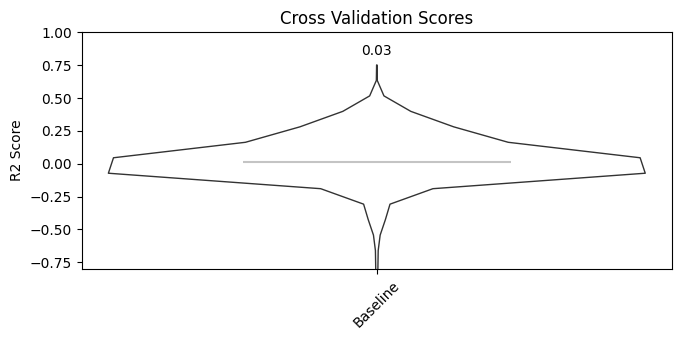

In [ ]:
# cross validation score
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), sharey=False)
data_dict = cv_scores_genes_dict

offset_amount = 0.4  # Control the offset amount for plots and text
legend_colors = ['purple', 'orange']
colors_map = {'purple': 'Inferred weight', 'orange': 'Inferred sign', 'white':''}
data_for_plot = []
labels_for_plot = []
positions = []
colors = []
current_position = 1
category_positions = {}  # Recalculating category positions
for key in data_dict.keys():
    
    data_for_plot.append(data_dict[key])
    category_label = surragate_names.get(key, key)
    if category_label not in category_positions:
        category_positions[category_label] = current_position
        labels_for_plot.append(category_label)
        current_position += 2
    positions.append(category_positions[category_label])
    colors.append('white')
violin_parts = ax.violinplot(data_for_plot, positions=positions, 
                             showmeans=False, 
                             showmedians=True, 
                             showextrema=False)
handles = []  # To store legend handles

for i, pc in enumerate(violin_parts['bodies']):
    color = colors[i]
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(.8)  # Ensuring the plot is fully opaque
    if colors_map[color] not in [h.get_label() for h in handles]:  # Avoid duplicate legend entries
        if color == 'white':
            continue
        handles.append(plt.Line2D([0], [0], color=color, linewidth=10, label=colors_map[color]))
keys = ['cmaxes', 'cmins', 'cbars', 'cmedians']
for key in keys:
    if key in violin_parts:
        violin_parts[key].set_edgecolor('#C4C4C4')

ax.set_xticks([pos for key, pos in category_positions.items()])
ax.set_xticklabels(labels_for_plot, rotation=45)
ax.set_title('Cross Validation Scores')
ax.set_ylabel('R2 Score')
ax.set_ylim([-.8, 1])
ax.legend(handles=handles, loc=(1.01,.8), frameon=False)
# Correcting text annotations with offset adjustments
for i, data in enumerate(data_for_plot):
    if len(data) == 0: continue  # Skip empty datasets
    mean_val = np.mean(data)
    text_pos = positions[i]
    plt.text(text_pos, max(data) + (0.1 * max(data)), f'{mean_val:.2f}', ha='center', color='black')
plt.tight_layout()
plt.show()

In [ ]:
[np.mean(cv_scores_genes_dict[name]) for name in cv_scores_genes_dict.keys()]
# cv_scores_genes_dict['baseline']

[-0.9802620572964151, -0.9910498698409012]

## Kaggle score
We can only submit if they are build on original data

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
os.environ['KAGGLE_USERNAME'] = 'jalilnourisa'
os.environ['KAGGLE_KEY'] = '63552f12403af36f40106e6821e80327'
api = KaggleApi()
api.authenticate()
# prefix = 'tfactivity_shuffled'  
prefix =  'trial2' 

gene_names = df_main_reg.columns

os.makedirs('../output/submits/', exist_ok=True)

def format_y_submit(Y_submit):
    y_submit_df = pd.DataFrame(Y_submit, columns=gene_names)
    y_submit_df.index.name = 'id'
    y_submit_df = y_submit_df.round(5)
    return y_submit_df
def write_submit(Y_submit_df, file_name):
    Y_submit_df.to_csv(f'../output/submits/{file_name}.csv')
def submit(file_name):
    filename = f"../output/submits/{file_name}.csv"
    competition = "open-problems-single-cell-perturbations"
    api.competition_submit(file_name=filename, message=file_name, competition=competition)

for name, model in enc_models.items():
    if name in ['baseline', 'collectRI_sign']:
        continue
    file_name = f'{prefix}_{name}'
    print(name)
    y_submit = model.calculate_y_submit()
    y_submit_df = format_y_submit(y_submit)
    write_submit(y_submit_df, file_name)
    submit(file_name)
### kaggle scores
def get_kaggle_scores(prefix):
    submissions = api.competition_submissions("open-problems-single-cell-perturbations")
    kaggle_scores_dict = {}
    for submission in submissions:
        kaggle_scores_dict[submission.fileName.replace('.csv', '')] = [submission.publicScore,  submission.privateScore]
    kaggle_scores_dict = {key:values for key,values in kaggle_scores_dict.items() if (prefix in key)}
    kaggle_scores_df = pd.DataFrame(kaggle_scores_dict.values(), index=kaggle_scores_dict.keys(), columns=['public_test', 'private_test']).reset_index().rename(columns={'index':'grn_model'})
    kaggle_scores_df.grn_model = kaggle_scores_df.grn_model.str.replace(f'{prefix}_','')
    return kaggle_scores_df
get_kaggle_scores(prefix)

## Robustness analysis

### Random baseline

In [ ]:
# pool the predictions
y_submits = []
for name, enc_model in tqdm.tqdm(enc_models.items()):
    y_submits.append(enc_model.calculate_y_submit())
pool_ = np.concatenate([np.ndarray.flatten(y_submit) for y_submit in y_submits])


  0%|          | 0/2 [00:00<?, ?it/s]


AttributeError: 'model_encoder_raw' object has no attribute 'calculate_y_submit'

In [ ]:
y_submit_format = format_y_submit(y_submits[0])
y_submits_random = []
for i in range(100):
    y_submits_random.append(format_y_submit(np.random.choice(pool_, size=y_submit_format.shape)))

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
os.environ['KAGGLE_USERNAME'] = 'jalilnourisa'
os.environ['KAGGLE_KEY'] = '63552f12403af36f40106e6821e80327'
api = KaggleApi()
api.authenticate()
prefix = 'random'    

for i, y_submit_df in enumerate(y_submits_random):
    if i < 17:
        continue
    file_name = f'{prefix}_{i}'
    write_submit(y_submit_df, file_name)
    submit(file_name)

### Shuffle grn 

In [ ]:
prefix = 'shuffletest_100tf'
for name, grn in zip(['co_grn', 'figr_grn'], [co_grn, figr_grn]):
    file_name = f'{prefix}_{name}'
    print(file_name)
    y_submit = enc_model.calculate_y_submit()
    y_submit_df = format_y_submit(y_submit)
    write_submit(y_submit_df, file_name)
    submit(file_name)

    for i in range(20,100):
        grn_s = grn.copy()
        grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
        grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)

        dup_flags = grn_s[['source','target']].duplicated()
        grn_s = grn_s[~dup_flags].reset_index(drop=True)
        if grn_s.duplicated().sum()>0:
            raise ValueError('')
        #-- create the model
        sm_name_svd_n = 100
        celltype_svd_n = 100

        enc_model = model_encoder(df_main_reg, grn_model=grn_s, shares={
                                            'sm_name':{'tf_x':sm_name_svd_n},
                                            'cell_type': {'tf_x':celltype_svd_n}
                                            })
        file_name = f'{prefix}_{name}_{i}'
        print(file_name)
        y_submit = enc_model.calculate_y_submit()
        y_submit_df = format_y_submit(y_submit)
        write_submit(y_submit_df, file_name)
        submit(file_name)

In [ ]:
df = get_kaggle_scores(prefix)
real  = df[df.grn_model=='figr_grn']
rest = df[df.grn_model!='figr_grn']
for score in ['public_test', 'private_test']:
    # print(rest[score].astype(float).mean())
    print(real[score].mean(), rest[score].astype(float).mean())

# df = get_kaggle_scores(prefix)
real  = df[df.grn_model=='co_grn']
rest = df[df.grn_model!='co_grn']
for score in ['public_test', 'private_test']:
    # print(rest[score].astype(float).mean())
    print(real[score].mean(), rest[score].astype(float).mean())

nan 0.5975
nan 0.7757000000000001
nan 0.5975
nan 0.7757000000000001


In [ ]:
from scipy import stats
real  = df[df.grn_model=='co_grn']
rest = df[df.grn_model!='co_grn']
for score in ['public_test', 'private_test']:
    # print(rest[score].astype(float).mean())
    print(real[score].mean(), rest[score].astype(float).mean())
    # Sample data: Replace 'sample_data' with your sample data array
    sample_data = rest[score].astype(float).values

    # # The single value you want to compare the sample against
    population_mean = real[score].astype(float).values[0]

    # # Perform the one-sample t-test
    print(population_mean)
    t_stat, p_value = stats.ttest_1samp(sample_data, population_mean)
    print(p_value)

0.594 0.6010487804878049
0.594
7.689253429425053e-09
0.767 0.7763170731707317
0.767
4.029174197131669e-09


In [ ]:
np.mean(cv_scores)

/root/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

## Plot 

In [ ]:
kaggle_scores_df = pd.read_csv('../output/postprocess/kaggle_scores_df.csv', index_col=0)
with open(f'../output/postprocess/CV/cv_scores_genes_dict_{original_data}_{only_sig_de}_{subset_genes}.json', 'r') as file:
    cv_scores_genes_dict = json.load(file)
    cv_scores_genes_dict = {key:np.asarray(values) for key,values in cv_scores_genes_dict.items()}

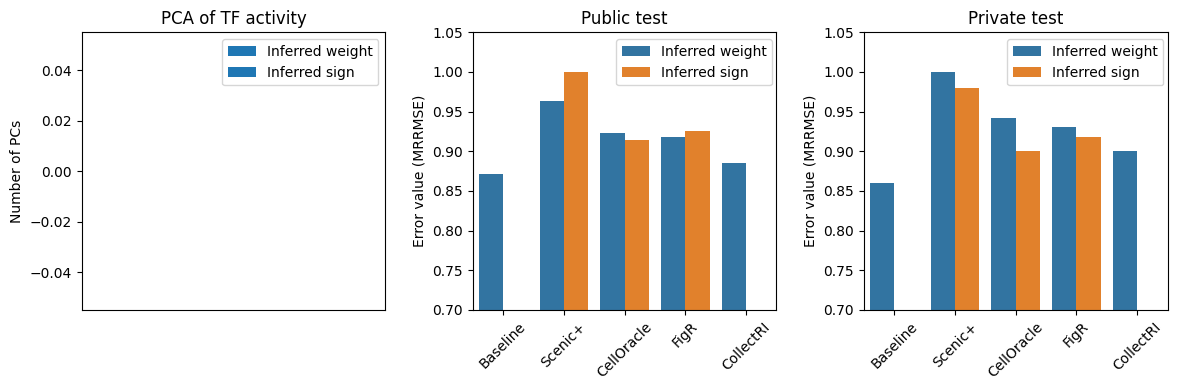

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

# n components for TF acts
ax = axes[0]
data_dict = n_components_dict
normal_data = {k: v for k, v in data_dict.items() if "_sign" not in k}
signed_data = {k.replace("_sign", ""): v for k, v in data_dict.items() if "_sign" in k}
labels = list(normal_data.keys())
normal_values = [normal_data[label] for label in labels]
signed_values = [0 if (label=='collectRI') else signed_data[label] for label in labels ]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
rects1 = ax.bar(x - width/2, normal_values, width, label='Inferred weight')
rects2 = ax.bar(x + width/2, signed_values, width, label='Inferred sign')
ax.set_ylabel('Number of PCs')
ax.set_title('PCA of TF activity')
ax.set_xticks(x)
ax.set_xticklabels([surragate_names[label] for label in labels], rotation=45)
ax.legend()
# public and private test scores 
axes_ = axes[1:3]
def categorize_model(row):
    if '_sign' in row['grn_model']:
        return 'Inferred sign'
    else:
        return 'Inferred weight'
kaggle_scores_df['model_group'] = kaggle_scores_df['grn_model'].str.replace('_sign', '', regex=False)
kaggle_scores_df['category'] = kaggle_scores_df.apply(categorize_model, axis=1)
kaggle_scores_df['public_test'] = pd.to_numeric(kaggle_scores_df['public_test'], errors='coerce')
kaggle_scores_df['private_test'] = pd.to_numeric(kaggle_scores_df['private_test'], errors='coerce')
for i, score_type in enumerate(['public_test', 'private_test']):
    kaggle_scores_df[score_type] = kaggle_scores_df[score_type]/max(kaggle_scores_df[score_type])
    ax = axes_[i]
    sns.barplot(x='model_group', y=score_type, 
                hue='category', 
                data=kaggle_scores_df, 
                ax=ax, 
                dodge=True,
                )
    ax.set_title(f'{score_type.replace("_", " ").capitalize()}')
    ax.set_xticklabels([surragate_names[label] for label in kaggle_scores_df.model_group.unique()])
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Error value (MRRMSE)')
    ax.legend(title='', loc='upper left', bbox_to_anchor=(.45, 1))
    ax.set_ylim(0.7, 1.05)  # Adjust y-axis range

plt.tight_layout()


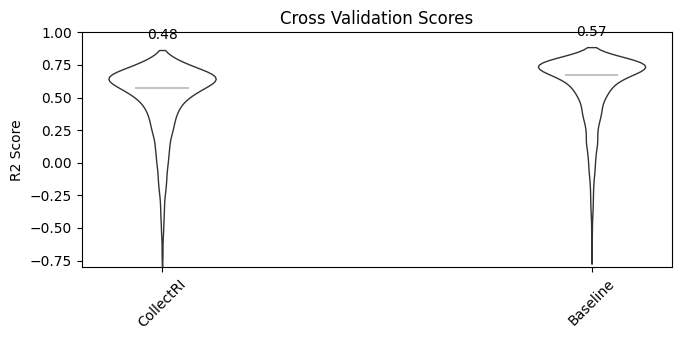

In [ ]:
# cross validation score
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), sharey=False)
data_dict = cv_scores_genes_dict

offset_amount = 0.4  # Control the offset amount for plots and text
legend_colors = ['purple', 'orange']
colors_map = {'purple': 'Inferred weight', 'orange': 'Inferred sign', 'white':''}
data_for_plot = []
labels_for_plot = []
positions = []
colors = []
current_position = 1
category_positions = {}  # Recalculating category positions
for key in data_dict.keys():
    if "sign" not in key and (key + "_sign") in data_dict:
        original_data_ = data_dict[key]
        signed_data = data_dict[key + "_sign"]
        data_for_plot += [original_data_, signed_data]
        category_label = surragate_names.get(key, key)
        if category_label not in category_positions:
            category_positions[category_label] = current_position
            labels_for_plot.append(category_label)
            current_position += 2  # Adjust for the next category, including space for offset
        # Adjust positions with the offset
        positions += [category_positions[category_label] - offset_amount, category_positions[category_label] + offset_amount]
        colors += legend_colors
    elif "baseline" in key or "collectRI" in key:
        data_for_plot.append(data_dict[key])
        category_label = surragate_names.get(key, key)
        if category_label not in category_positions:
            category_positions[category_label] = current_position
            labels_for_plot.append(category_label)
            current_position += 2
        positions.append(category_positions[category_label])
        colors.append('white')
violin_parts = ax.violinplot(data_for_plot, positions=positions, 
                             showmeans=False, 
                             showmedians=True, 
                             showextrema=False)
handles = []  # To store legend handles

for i, pc in enumerate(violin_parts['bodies']):
    color = colors[i]
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(.8)  # Ensuring the plot is fully opaque
    if colors_map[color] not in [h.get_label() for h in handles]:  # Avoid duplicate legend entries
        if color == 'white':
            continue
        handles.append(plt.Line2D([0], [0], color=color, linewidth=10, label=colors_map[color]))
keys = ['cmaxes', 'cmins', 'cbars', 'cmedians']
for key in keys:
    if key in violin_parts:
        violin_parts[key].set_edgecolor('#C4C4C4')

ax.set_xticks([pos for key, pos in category_positions.items()])
ax.set_xticklabels(labels_for_plot, rotation=45)
ax.set_title('Cross Validation Scores')
ax.set_ylabel('R2 Score')
ax.set_ylim([-.8, 1])
ax.legend(handles=handles, loc=(1.01,.8), frameon=False)
# Correcting text annotations with offset adjustments
for i, data in enumerate(data_for_plot):
    if len(data) == 0: continue  # Skip empty datasets
    mean_val = np.mean(data)
    text_pos = positions[i]
    plt.text(text_pos, max(data) + (0.1 * max(data)), f'{mean_val:.2f}', ha='center', color='black')
plt.tight_layout()
plt.show()


In [ ]:
violin_parts.keys()

dict_keys(['bodies', 'cmaxes', 'cmins', 'cbars', 'cmedians'])